In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be usedimport tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import pandas as pd
import math
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
MAX_HEIGHT = 1072
MAX_WIDTH = 1912
shrink = 8
HEIGHT = MAX_HEIGHT // shrink
WIDTH = MAX_WIDTH // shrink
batch_size = 64
print(HEIGHT, WIDTH)

134 239


In [6]:
tensor = tf.convert_to_tensor([1, 2, 3, 4], dtype=tf.float32)
tensor / 5

<tf.Tensor: id=2, shape=(4,), dtype=float32, numpy=array([0.2, 0.4, 0.6, 0.8], dtype=float32)>

In [7]:
def get_classes_info(root_dir: str, height, width):
    labels = set()
    counter = 0
    classes_num = {}
    with open(os.path.join(root_dir, 'preprocessed_localization.txt'), 'r') as file:
        for line in file:
            line = line.strip()
            character = line.split(',')[-1]
            if character not in labels:
                labels.add(character)
                classes_num[character] = 0
            classes_num[character] += 1
            counter += 1
    labels = sorted(list(labels))
    return labels, classes_num, counter

def convertion(labels: list):
    convert_to_categorical = {character: ind for ind, character in enumerate(labels)}
    return convert_to_categorical

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image /= 255.0
    return image


def load_and_preprocess(image_path):
    image = tf.io.read_file(image_path)
    return preprocess_image(image)

def parse_input(root_dir: str, height, width):
    image_paths = []
    answers_coord = []
    answers_class = []
    answers = []
    file_path = os.path.join(root_dir, 'preprocessed_localization.txt')
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip().split(',')
            x_1, y_1, x_2, y_2 = map(int, line[1:5])
            # x_1, x_2 = min(x_1, x_2), max(x_1, x_2)
            # y_1, y_2 = min(y_1, y_2), max(y_1, y_2)
            image_path = line[0]
            coords = (x_1, y_1, x_2, y_2)
            image = load_and_preprocess(image_path)
            image_paths.append(image_path)
            answers_coord.append(coords)
            answers_class.append(tf.keras.utils.to_categorical(convert_to_categorical[line[5]], len(labels)))
            # answers.append((answers_coord[-1], answers_class[-1]))
            answers.append((answers_coord[-1], answers_class[-1]))
    return image_paths, answers_coord, answers_class, answers

In [8]:
labels, classes_num, total = get_classes_info('the-simpsons-characters-dataset', 0, 0)
# print(labels)
for character, cnt in sorted(classes_num.items(), key=lambda x: -x[1]):
    print(character, ':', cnt)
print('\n' + str(total))
print(len(labels))
convert_to_categorical = convertion(labels)
image_paths, answers_coord, answers_class, answers = parse_input('the-simpsons-characters-dataset', 0, 0)

charles_montgomery_burns : 1300
homer_simpson : 1224
abraham_grampa_simpson : 1190
ned_flanders : 1190
lisa_simpson : 1124
marge_simpson : 1114
bart_simpson : 1108
principal_skinner : 1012
krusty_the_clown : 452
nelson_muntz : 438
moe_szyslak : 430
kent_brockman : 426
edna_krabappel : 424
milhouse_van_houten : 420
chief_wiggum : 418
comic_book_guy : 416
apu_nahasapeemapetilon : 412
sideshow_bob : 406

13504
18


In [9]:
len(image_paths), len(answers_coord), len(answers_class), len(answers)

(13504, 13504, 13504, 13504)

In [10]:
def show_image_with_box(image_path, coord, character):
    image = load_and_preprocess(image_path)
    plt.imshow(image)
    plt.axvline(x=coord[0],color='red')
    plt.axvline(x=coord[2],color='red')
    plt.axhline(y=coord[1],color='red')
    plt.axhline(y=coord[3],color='red')
    plt.xlabel(labels[character.argmax()])
    # plt.show()

In [11]:
x1, y1, x2, y2 = answers_coord[5000]
x1, y1, x2, y2

(65, 2, 152, 116)

In [12]:
character = answers_class[2022].argmax()
labels[character]

'bart_simpson'

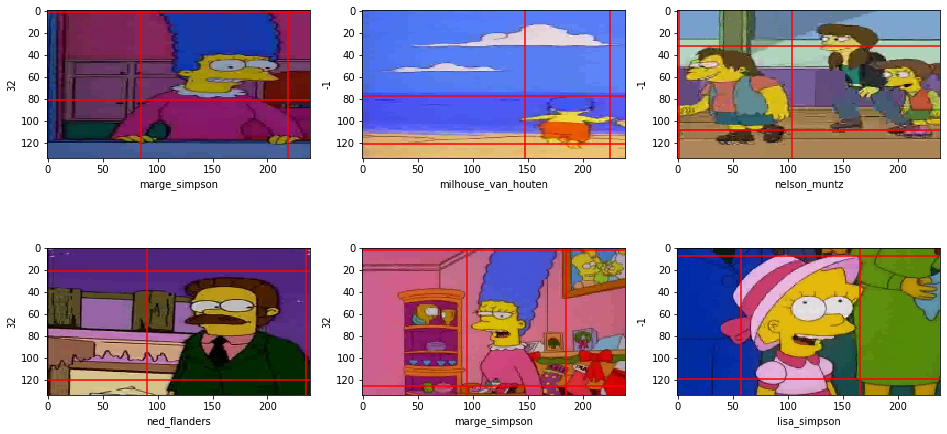

In [13]:
sizes = len(answers_coord)
plt.figure(figsize=(16, 8))
i = 0
for ind in [random.randint(0, sizes - 1) for x in range(6)]:
    plt.subplot(2, 3,i+1)
    show_image_with_box(image_paths[ind], answers_coord[ind], answers_class[ind])
    plt.ylabel(image_paths[ind].find('mirrored_dataset'))
    i += 1
plt.show()

In [14]:
print(answers[0][:4])
print(answers[0][4:])

((22, 23, 24, 23), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32))
()


In [15]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, answers, test_size=0.15, random_state=42, shuffle=True)
train_size = len(X_train)
test_size = len(X_test)

In [16]:
len(X_train), len(y_train), train_size, len(X_test), len(y_test), test_size

(11478, 11478, 11478, 2026, 2026, 2026)

In [17]:
X_train

['the-simpsons-characters-dataset/simpsons_dataset/principal_skinner/pic_0410.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/charles_montgomery_burns/pic_0151.jpg',
 'the-simpsons-characters-dataset/simpsons_dataset/ned_flanders/pic_0747.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/milhouse_van_houten/pic_0153.jpg',
 'the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_1054.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/nelson_muntz/pic_0143.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/nelson_muntz/pic_0158.jpg',
 'the-simpsons-characters-dataset/simpsons_dataset/bart_simpson/pic_0448.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/charles_montgomery_burns/pic_0521.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/charles_montgomery_burns/pic_1126.jpg',
 'the-simpsons-characters-dataset/mirrored_dataset/krusty_the_clown/pic_0764.jpg',
 'the-simpsons-characters-dataset/simpsons_dataset/apu_nahasapeemapetilon/pic_0

In [18]:
X_train[1], labels[y_train[1][1].argmax()]

('the-simpsons-characters-dataset/mirrored_dataset/charles_montgomery_burns/pic_0151.jpg',
 'charles_montgomery_burns')

In [19]:
abc = np.append(y_train[0][0], y_train[0][1])
y_train[6]

((44, 16, 167, 116),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.], dtype=float32))

In [20]:
kek, pog = zip(*y_test)
pog
# coord_labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(kek, tf.float32))
class_labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(pog, tf.float32))
for elem in class_labels_ds.take(1):
    print(elem)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(18,), dtype=float32)


In [21]:
batch_size = 64
AUTOTUNE

-1

In [22]:
def make_dataset(paths, answers, size):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    # label_ds = tf.data.Dataset.from_tensor_slices(answers) #tf.cast(answers, tf.float32))
    coords, classes = zip(*answers)
    coord_labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(coords, tf.float32))
    class_labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(classes, tf.float32))
    # answer_ds = tf.data.Dataset.zip((coord_labels_ds, class_labels_ds))
    image_and_label_ds = tf.data.Dataset.zip((image_ds, (coord_labels_ds, class_labels_ds)))
    ds = image_and_label_ds.shuffle(buffer_size=size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    print(batch_size)
    return ds

In [23]:
train_ds = make_dataset(X_train, y_train, train_size)
test_ds = make_dataset(X_test, y_test, test_size)

64
64


In [24]:
train_ds.take(1)

<TakeDataset shapes: ((None, 134, 239, 3), ((None, 4), (None, 18))), types: (tf.float32, (tf.float32, tf.float32))>

In [49]:
def get_model():
    basic_dropout = 0.25
    mlp_dropout = 0.5
    tf.keras.backend.clear_session()
    input_layer = keras.Input(shape=(HEIGHT, WIDTH, 3), name='image')
    
    x = layers.Conv2D(16, 3, activation='relu')(input_layer)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(basic_dropout)(x)
    
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(basic_dropout)(x)
    
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(256, 3, activation='relu')(x)
    # x = layers.MaxPooling2D()(x)
    # x = layers.Dropout(basic_dropout)(x)
    
    # x = layers.Conv2D(256, 3, activation='relu')(x)
    # x = layers.Dropout(basic_dropout)(x)
    
    x = layers.GlobalMaxPool2D()(x)
    # x = layers.Flatten()(x)
    
    # classification = layers.Dropout(mlp_dropout)(x)
    classification = layers.Dense(400, activation='relu')(x)
    classification = layers.Dropout(mlp_dropout)(classification)
    # classification = layers.Dense(256, activation='relu')(x)
    # classification = layers.Dropout(mlp_dropout)(classification)
    classification = layers.Dense(len(labels), activation='softmax', name='classification')(classification)
    
    localization = layers.Dense(512, activation='relu')(x)
    localization = layers.Dropout(basic_dropout)(localization)
    localization = layers.Dense(256, activation='relu')(x)
    localization = layers.Dropout(basic_dropout)(localization)
    localization = layers.Dense(256, activation='relu')(x)
    localization = layers.Dropout(basic_dropout)(localization)
    localization = layers.Dense(4, activation='relu', name='localization')(localization)
    
    model = keras.Model(inputs=input_layer, outputs=[localization, classification], name='classification_localizaion_model')
    return model

In [50]:
model = get_model()
# model.summary()

In [51]:
keras.utils.plot_model(model, '%s.png' % model.name, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [52]:
def classification_loss(y_true, y_pred):
    return keras.losses.categorical_crossentropy(y_true, y_pred)

# def localizaion_loss(y_true, y_pred):
#     return tf.math.log((keras.losses.mse(y_true , y_pred)))
def localizaion_loss(y_true, y_pred):
    return tf.math.log(keras.losses.mse(y_true , y_pred))

In [53]:
model.compile(optimizer='Adam',
             loss={'classification': keras.losses.CategoricalCrossentropy(from_logits=False),
                  'localization': localizaion_loss
                  },
              metrics={'classification': 'accuracy',
                      'localization': keras.metrics.mse},
              loss_weights=[0.5, 1],
             )

In [54]:
history = model.fit(train_ds,
                    steps_per_epoch=train_size // batch_size,
                    validation_data=test_ds,
                    validation_steps=test_size // batch_size,
                    epochs=80
                  )

Train for 179 steps, validate for 31 steps
Epoch 1/80
179/179 [==============================] - 20s 111ms/step - loss: 6.5062 - localization_loss: 7.3917 - classification_loss: 2.8104 - localization_mean_squared_error: 3986.5828 - classification_accuracy: 0.0889 - val_loss: 6.2451 - val_localization_loss: 6.9734 - val_classification_loss: 2.7584 - val_localization_mean_squared_error: 1539.3596 - val_classification_accuracy: 0.1305
Epoch 2/80
179/179 [==============================] - 16s 92ms/step - loss: 5.9831 - localization_loss: 6.5924 - classification_loss: 2.6869 - localization_mean_squared_error: 1161.3075 - classification_accuracy: 0.1468 - val_loss: 5.8705 - val_localization_loss: 6.5327 - val_classification_loss: 2.6041 - val_localization_mean_squared_error: 1074.3567 - val_classification_accuracy: 0.1729
Epoch 3/80
179/179 [==============================] - 15s 86ms/step - loss: 5.8726 - localization_loss: 6.5877 - classification_loss: 2.5788 - localization_mean_squared_err

Epoch 22/80
179/179 [==============================] - 17s 95ms/step - loss: 3.6287 - localization_loss: 6.2967 - classification_loss: 0.4803 - localization_mean_squared_error: 978.1234 - classification_accuracy: 0.8426 - val_loss: 3.5499 - val_localization_loss: 6.4823 - val_classification_loss: 0.3087 - val_localization_mean_squared_error: 1061.0669 - val_classification_accuracy: 0.8997
Epoch 23/80
179/179 [==============================] - 17s 95ms/step - loss: 3.5957 - localization_loss: 6.2922 - classification_loss: 0.4497 - localization_mean_squared_error: 962.4803 - classification_accuracy: 0.8561 - val_loss: 3.4836 - val_localization_loss: 6.3613 - val_classification_loss: 0.3030 - val_localization_mean_squared_error: 992.4087 - val_classification_accuracy: 0.9042
Epoch 24/80
179/179 [==============================] - 16s 88ms/step - loss: 3.5568 - localization_loss: 6.2815 - classification_loss: 0.4161 - localization_mean_squared_error: 964.5219 - classification_accuracy: 0.86

Epoch 43/80
179/179 [==============================] - 17s 95ms/step - loss: 3.3163 - localization_loss: 6.1619 - classification_loss: 0.2354 - localization_mean_squared_error: 900.8409 - classification_accuracy: 0.9225 - val_loss: 3.3249 - val_localization_loss: 6.2338 - val_classification_loss: 0.2080 - val_localization_mean_squared_error: 904.8257 - val_classification_accuracy: 0.9350
Epoch 44/80
179/179 [==============================] - 17s 96ms/step - loss: 3.2880 - localization_loss: 6.1548 - classification_loss: 0.2106 - localization_mean_squared_error: 899.1642 - classification_accuracy: 0.9321 - val_loss: 3.3396 - val_localization_loss: 6.2742 - val_classification_loss: 0.2026 - val_localization_mean_squared_error: 960.3521 - val_classification_accuracy: 0.9289
Epoch 45/80
179/179 [==============================] - 17s 96ms/step - loss: 3.2873 - localization_loss: 6.1654 - classification_loss: 0.2045 - localization_mean_squared_error: 897.9625 - classification_accuracy: 0.933

Epoch 64/80
179/179 [==============================] - 17s 94ms/step - loss: 3.1640 - localization_loss: 6.0619 - classification_loss: 0.1331 - localization_mean_squared_error: 853.6317 - classification_accuracy: 0.9582 - val_loss: 3.1882 - val_localization_loss: 6.1161 - val_classification_loss: 0.1301 - val_localization_mean_squared_error: 871.4132 - val_classification_accuracy: 0.9572
Epoch 65/80
179/179 [==============================] - 17s 93ms/step - loss: 3.1639 - localization_loss: 6.0621 - classification_loss: 0.1328 - localization_mean_squared_error: 854.4191 - classification_accuracy: 0.9553 - val_loss: 3.2084 - val_localization_loss: 6.0897 - val_classification_loss: 0.1636 - val_localization_mean_squared_error: 856.3419 - val_classification_accuracy: 0.9491
Epoch 66/80
179/179 [==============================] - 17s 93ms/step - loss: 3.1825 - localization_loss: 6.0783 - classification_loss: 0.1433 - localization_mean_squared_error: 856.2670 - classification_accuracy: 0.954

In [55]:
image = load_and_preprocess(X_test[2])
exp_image = tf.expand_dims(image, 0)
exp_image.shape

TensorShape([1, 134, 239, 3])

In [56]:
y_test[2]

((25, 13, 142, 99),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float32))

In [57]:
coords, character = model.predict(exp_image)
coords

array([[ 58.317467,   9.991015, 188.39134 , 124.72154 ]], dtype=float32)

In [61]:
def show_ans(image, coords, character, color: str = 'red'):
    plt.imshow(image)
    coords = list(map(int,coords[0]))
    plt.plot([coords[0], coords[2], coords[2], coords[0], coords[0]], [coords[1], coords[1], coords[3], coords[3], coords[1]], color=color, linewidth=5)
    # plt.xlabel(labels[character.argmax()])
    plt.xlabel('%s\nprobability: %.2f%%' % (labels[character.argmax()], 100 * character.max()))
    plt.xticks([])
    plt.yticks([])

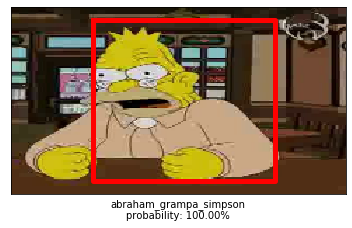

In [62]:
show_ans(image, coords, character)
plt.show()

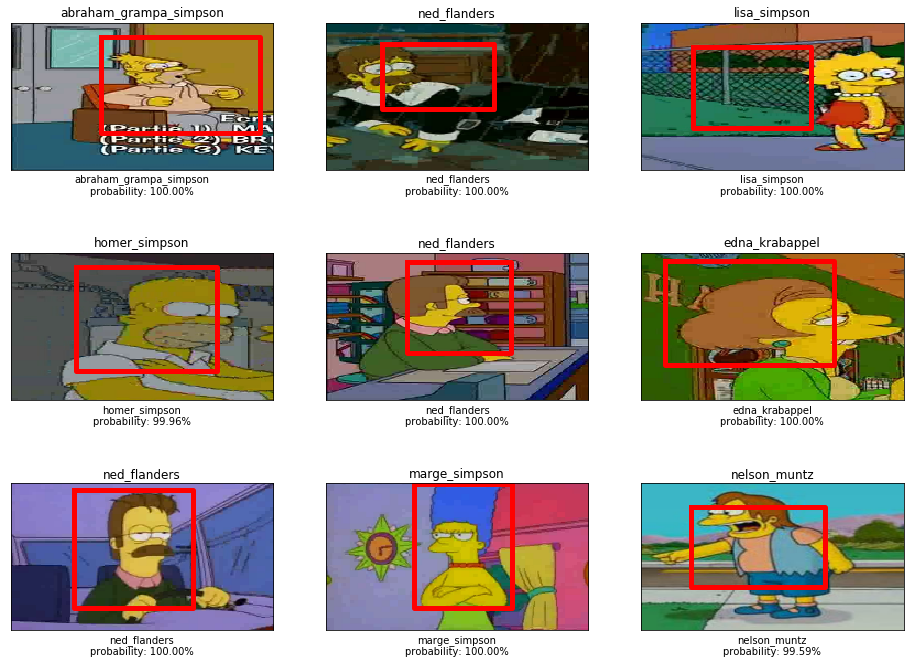

In [88]:
sizes = len(y_test)
plt.figure(figsize=(16, 12))
i = 0
for ind in [random.randint(0, sizes - 1) for x in range(9)]:
    image = load_and_preprocess(X_test[ind])
    exp_image = tf.expand_dims(image, 0)
    coords, character = model.predict(exp_image)
    plt.subplot(3, 3,i+1)
    show_ans(image, coords, character)
    plt.title(labels[y_test[ind][1].argmax()])
    i += 1
plt.show()

In [89]:
df = pd.DataFrame(history.history)
df.to_csv('models/localizaion/localization4.csv')